In [ ]:
# Strategy:
#
# STEP 1:
#  * load training data for each machine (only normal sounds)
#  * extract each vertical lines from spectrogram as a vector, and complete with machine ID
#  * store these vectors in a global matrix
#  * train a classifier which compute probability of appartenancy for each machine

In [ ]:
# Author : Antoine
# First try of classification with KNN
# use only fan data, use normal and anomalous data for training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Pour l'affichage d'images

from joblib import dump, load

from sklearn import neighbors
from sklearn.model_selection import train_test_split

#import numpy as np # Pour la manipulation de tableaux
#import pandas as pd # Pour manipuler des DataFrames pandas

from matplotlib import cm # Pour importer de nouvelles cartes de couleur
# %matplotlib inline

from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense # Pour instancier une couche dense
from keras.utils import np_utils

import itertools # Pour créer des iterateurs

from sklearn import metrics # Pour évaluer les modèles


In [ ]:
# clear all variables to clean RAM and avoid crashes
#import sys
#sys.modules[__name__].__dict__.clear()

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
machines = [            # TEST DATA SIZE
    'fan',              # (1875, 40065)
    'pump',             # (856, 40065)
    'slider',           # (1290, 40065)
    'valve',            # (879, 40065)
   # 'ToyCar',           # (2459, 44033)
   # 'ToyConveyor'       # (3509, 40065)
]

#machines = ['verif_1', 'verif_2']

# all images are 128px height
height = 128


In [ ]:
# use 90% of available images for model validation
test_size = 0.1

# reduce data for training by 90%
training_reduction = 0.8

# model settings
units = 120
epochs = 50

In [ ]:
id_machine = 0
codes_machines = [1,2,3,4,5,6]

# init empty array with expected width (equals image heigh + one for target)
global_train_array = np.empty([0, height+1])
global_test_array = np.empty([0, height+1])

set = 'train'

for machine in machines:

    # identifiant de la machine
    id_machine = id_machine + 1
    code_machine = codes_machines[id_machine-1]

    print(machine, '/', id_machine, '=>', code_machine)

    # example : '../data/fan/train_png/'
    # working_directory = '../../data/'+machine+'/'
    working_directory = '/drive/MyDrive/asdpy/data/'

    # data file example: df_fan_train.joblib
    # numpy ndarray
    # dernière colonne = type de donnée, normal ou anomalie
    data_array = load(working_directory + 'df_'+machine+'_'+set+'.joblib')

    # shuffle images
    np.random.shuffle(data_array)

    # limit data to spare RAM 
    if data_array.shape[0] > 2500:
      data_array = data_array[:2500,:]

    print(data_array.shape)

    nb_images = data_array.shape[0]

    nb_images_test = int(nb_images*test_size)
    nb_images_train = int(nb_images - nb_images_test)

    pixels = data_array.shape[1] - 1
    width = int(pixels/height)

    #print("nb_images : ", nb_images)
    #print("width : ", width)

    # remove last column, reshape to line by line format and transpose result
    loop_array = data_array[:,0:-1].reshape(height,width*nb_images).T

    # vector as long as vertical lines
    #id_machine_col = np.ones((width*nb_images,1), dtype=np.int16)*id_machine
    id_machine_col = np.ones((width*nb_images,1), dtype=np.int16)*code_machine
    

    # colle le vecteur à droite de l'array
    loop_array = np.append(loop_array, id_machine_col, axis=1)

    # ajoute au tableau global
    global_train_array = np.append(global_train_array, loop_array[:nb_images_train*width], axis=0)
    global_test_array = np.append(global_test_array, loop_array[nb_images_train*width:], axis=0)

    # 14 minutes pour les 4 premieres machines...
    # 16 secondes pour 5 machines une fois optimisé
    # 45 secondes avec les 6 jeux de train et bridage à 2500 lignes par jeu

# free RAM
del data_array
del loop_array


fan / 1 => 1
(2500, 40065)
pump / 2 => 2
(2500, 40065)
slider / 3 => 3
(2500, 40065)
valve / 4 => 4
(2500, 40065)


In [ ]:
print('global_train_array.shape : ')
print(global_train_array.shape)
# (3'340'750, 129)

print('global_test_array.shape : ')
print(global_test_array.shape)
# 1'431'750

global_train_array.shape : 
(2817000, 129)
global_test_array.shape : 
(313000, 129)


In [ ]:
print(global_train_array)

[[0.94509804 0.71764708 0.6156863  ... 0.25882354 0.52156866 1.        ]
 [0.94509804 0.67843139 0.6156863  ... 0.36862746 0.52156866 1.        ]
 [0.97254902 0.7019608  0.58039218 ... 0.47450981 0.53725493 1.        ]
 ...
 [0.53725493 0.74901962 0.6156863  ... 0.60000002 0.87450981 4.        ]
 [0.54901963 0.75686276 0.58039218 ... 0.52549022 0.89411765 4.        ]
 [0.60000002 0.80392158 0.58823532 ... 0.49411765 0.87450981 4.        ]]


In [ ]:
print("PREPARE TRAINING DATAFRAMES...")

training_samples = int(global_train_array.shape[0]*(1-training_reduction))
print(training_samples)

# réduit la dimension de l'array pour les tests
np.random.shuffle(global_train_array) 
data = global_train_array[0:2000*1000]
train_df = pd.DataFrame(data)

# séparation des données de la cible
X_train = train_df.iloc[:,0:-1]
y_train = train_df.iloc[:,-1:]

print("PREPARE VALIDATION DATAFRAMES...")
# réduit la dimension de l'array pour les tests
np.random.shuffle(global_test_array) 
data = global_test_array[0:1000*1000]
test_df = pd.DataFrame(data)

# séparation des données de la cible
X_test = test_df.iloc[:,0:-1]
y_test = test_df.iloc[:,-1:]

# séparation des données d'entrainement (70%) et de test (30%)
# méthode inneficace pour ce projet
#X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.30, random_state=66)

# delete not used variables to free RAM
del data
del global_train_array
del global_test_array
del train_df
del test_df

PREPARE TRAINING DATAFRAMES...
563399
PREPARE VALIDATION DATAFRAMES...


In [ ]:
y_train.value_counts()

y_train.min() # 128    1.0
y_train.max() # 128    6.0

# y_train.shape # (1000000, 1)

print(y_train)

print(y_train.value_counts())
print(y_test.value_counts())

         128
0        3.0
1        1.0
2        1.0
3        2.0
4        4.0
...      ...
1999995  2.0
1999996  1.0
1999997  4.0
1999998  2.0
1999999  2.0

[2000000 rows x 1 columns]
128
1.0    500204
4.0    500072
3.0    500024
2.0    499700
dtype: int64
128
4.0    78250
3.0    78250
2.0    78250
1.0    78250
dtype: int64


In [ ]:
y_train_cat = np_utils.to_categorical(y_train, dtype = 'int64')
y_test_cat = np_utils.to_categorical(y_test, dtype = 'int64')

print("y_train_cat.shape")
print(y_train_cat.shape)

print("y_test_cat.shape")
print(y_test_cat.shape)

num_pixels = X_train.shape[1]
num_classes = y_test_cat.shape[1]

print("num_classes : ", num_classes)

y_train_cat.shape
(2000000, 5)
y_test_cat.shape
(313000, 5)
num_classes :  5


In [ ]:
# Étape 1 : Instancier un modèle avec le constructeur Sequential
model = Sequential()

# Étape 2 : Instancier les couches qui composeront le modèle avec leur constructeur
first_layer = Dense(units=units,                # nombre de neurones
                    activation='tanh',          # fonction d'activation
                    input_dim=num_pixels,       # dimension du vecteur d'entrée
                    kernel_initializer="normal" # vecteur de poids de cette couche initialisés aléatoirement selon la loi normale
            )

# Étape 3 : Ajouter les couches au modèle grâce
second_layer = Dense(units=num_classes,          # nombre de neurones de sortie égal au nombre de classes
                     activation='softmax',       # fonction d'activation
                     #input_dim=20,               # dimension du vecteur d'entrée égale à la sortie de la couche précédente
                     kernel_initializer="normal" # vecteur de poids de cette couche initialisés aléatoirement selon la loi normale
            )

# Ajout des couches aux modèle
model.add(first_layer)
model.add(second_layer)

model.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme d'optimisation
              metrics=['accuracy'])             # métrique d'évaluation


# TPU 200/batch : 2ms/step
# TPU 2000/batch : 8ms/step
training_history = model.fit(X_train, y_train_cat, epochs=epochs, batch_size=2000, validation_split=0.2)

Epoch 1/50
800/800 [==============================] - 23s 12ms/step - loss: 1.0595 - accuracy: 0.5966 - val_loss: 0.6921 - val_accuracy: 0.7285
Epoch 2/50
800/800 [==============================] - 8s 10ms/step - loss: 0.6834 - accuracy: 0.7337 - val_loss: 0.6500 - val_accuracy: 0.7484
Epoch 3/50
800/800 [==============================] - 8s 10ms/step - loss: 0.6393 - accuracy: 0.7535 - val_loss: 0.5921 - val_accuracy: 0.7738
Epoch 4/50
800/800 [==============================] - 8s 10ms/step - loss: 0.5793 - accuracy: 0.7795 - val_loss: 0.5414 - val_accuracy: 0.7942
Epoch 5/50
800/800 [==============================] - 8s 10ms/step - loss: 0.5242 - accuracy: 0.8021 - val_loss: 0.4841 - val_accuracy: 0.8193
Epoch 6/50
800/800 [==============================] - 8s 10ms/step - loss: 0.4739 - accuracy: 0.8226 - val_loss: 0.4363 - val_accuracy: 0.8391
Epoch 7/50
800/800 [==============================] - 9s 12ms/step - loss: 0.4299 - accuracy: 0.8409 - val_loss: 0.4054 - val_accuracy: 0.850

In [ ]:
# sauvegarde du modèle
# https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb#scrollTo=Rx-z3Qwx5RnB
model_save_name = 'nn1.h5'
path = F"/drive/MyDrive/asdpy/models/{model_save_name}" 

model.save(path)

In [ ]:
#chargement du modèle
from keras.models import load_model

model_save_name = 'nn1.h5'
path = F"/drive/MyDrive/asdpy/models/{model_save_name}" 
model = load_model(path)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               15480     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 605       
Total params: 16,085
Trainable params: 16,085
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

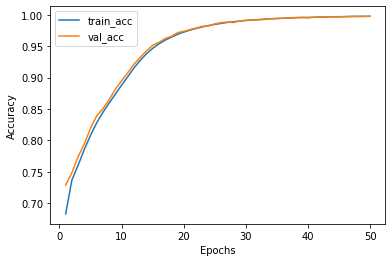

In [ ]:
plt.plot(np.arange(1 , len(train_acc)+1, 1), train_acc, label="train_acc")
plt.plot(np.arange(1 , len(train_acc)+1, 1), val_acc, label="val_acc")

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# prédiction des données
# about 40 seconds
#test_pred = model.predict(X_test)

# score du modèle
score = model.evaluate(X_test, y_test_cat)
print(score)

# Prediction de l'échantillon de test
test_pred = model.predict(X_test)

test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = np.argmax(y_test_cat, axis=1)

print("Performances du modele :")
print(metrics.classification_report(y_test_class, test_pred_class))

9782/9782 [==============================] - 11s 1ms/step - loss: 3.1972 - accuracy: 0.3480
[3.1971800327301025, 0.3480095863342285]
Performances du modele :
              precision    recall  f1-score   support

           1       0.46      0.38      0.41     78250
           2       0.32      0.51      0.40     78250
           3       0.39      0.28      0.32     78250
           4       0.26      0.22      0.24     78250

    accuracy                           0.35    313000
   macro avg       0.36      0.35      0.34    313000
weighted avg       0.36      0.35      0.34    313000



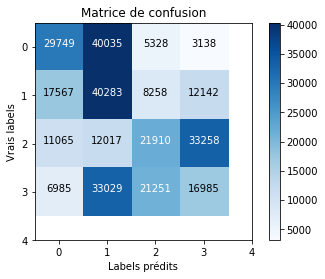

In [ ]:
# affiche la matrice de confusion sous forme de tableau coloré
classes = range(0,num_classes)

plt.figure()

# matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# texte et couleur
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()



In [ ]:
print("RECAP")

print("test_size : ", test_size)
print("training_reduction : ", training_reduction)
print("units : ", units)
print("epochs : ", epochs)
print("score : ", score)


RECAP
test_size :  0.1
training_reduction :  0.8
units :  120
epochs :  50
score :  [3.1971800327301025, 0.3480095863342285]


In [ ]:
# show memory usage for each variable
# https://stackoverflow.com/a/51046503
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       X_train:  1.9 GiB
                        X_test: 305.7 MiB
                       y_train: 15.3 MiB
                     test_pred:  6.0 MiB
                        y_test:  2.4 MiB
               test_pred_class:  2.4 MiB
                  y_test_class:  2.4 MiB
                id_machine_col:  1.5 MiB
                           _i7:  2.2 KiB
                          _i13:  1.5 KiB
